# Visualization

This notebook hosts functions and visualizations for tasks 1, 2, and 3. These tasks are explained in detail as the notebook progresses. The main objective with these tasks are to better understand visitation for all dinosaur articles on Wikipedia. The data is read in from the Wikipedia API found in `get_data.ipynb`.

### Get all necessary libraries

In [1]:
import json, time, collections
import pandas as pd
import numpy as np
import seaborn as sns

## Reusable functions for data preperation, cleaning and plotting.

In [32]:
def get_dataframe_from_json(json_file_name: str) -> pd.DataFrame:
    ''' Opens JSON file and formats to DataFrame for analysis '''
    with open(json_file_name ,"r") as file:
        views = json.load(file)
        
    df = pd.DataFrame([])

    for k,v in views.items():
        df = pd.concat([df, pd.DataFrame(v)])
    
    return df

def convert_timestamp_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    '''Format the timestamp attribute to DateTime objects for data comparisons'''
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%d%H")
    return df

def filter_articles_by_name(df: pd.DataFrame, article_names: list) -> pd.DataFrame:
    '''Helper function used in all tasks for filtering a dataframe by article name'''
    return df[df['article'].isin(article_names)].reindex()

def find_min_max_average_article_names(df: pd.DataFrame) -> list:
    '''Helper function used for task 1 to get max and min article names. The task explains necessity.'''
    min_max_df = desktop_df.groupby(by='article', as_index=False).mean().sort_values(by=['views'], ascending=False).iloc[[0, -1]]
    return list(min_max_df['article'].values)

def find_top_10_peak_views_articles(df: pd.DataFrame) -> list:
    '''Helper function used for task 2 to get top 10 article names. The task explains necessity.'''
    top_10 = df.groupby('article', as_index=False).max().sort_values(by=['views'], ascending=False).iloc[:10]
    return list(top_10['article'].values)

def find_bottom_10_article_names(df: pd.DataFrame) -> list:
    '''Helper function used for task 3 to get bottom 10 article names. The task explains necessity.'''
    bottom_10 = df.groupby(['article'], as_index=False).count().sort_values(by=['timestamp']).iloc[:10]
    return list(bottom_10['article'].values)

### Read & Format Data 

> We read in all JSON data and reformat columns needed for visualization tasks. Here we only reformat the timestamp into datetime objects so that the computer understands and can perform time comparisons.

In [10]:
desktop_df = get_dataframe_from_json("data/dino_monthly_desktop_<201507>-<202209>.json")
mobile_df = get_dataframe_from_json("data/dino_monthly_mobile_<201507>-<202209>.json")
desktop_df = convert_timestamp_to_datetime(desktop_df)
mobile_df = convert_timestamp_to_datetime(mobile_df)
mobile_df.shape, desktop_df.shape

### Task 1

> Maximum Average and Minimum Average - A time series output for articles that have highest average page requests and lowest average page requests for both `desktop` and `mobile` access. 

This timeseries output will have four lines - the max desktop, min desktop, max mobile, and min mobile.

##### Helper Functions Specific for Task 1

In [27]:
def plot_min_max_articles(dataframes: list, labels: list, save_plot_name = None):
    '''
    Plotting function used only for task 1. Takes in series of DataFrames to plot and their respective labels.
    Optionally, you can save the figure by passing in a name for save_plot_name.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.lineplot()
    task_1_plot = None
    
    for i, df in enumerate(dataframes):
        task_1_plot = sns.lineplot(x="timestamp", y="views", data=df, color=sns.color_palette()[i], label=labels[i], linestyle="-")
        
    ax.set_xlabel("Number of Views", fontsize = 10)
    ax.set_ylabel("Year", fontsize = 10)
    ax.set_title('Number of views per year for maximum and minimum average viewed dinosaur articles on Wikipedia', fontsize=10)
    
    # if wanted to save plot
    if save_plot_name: 
        task_1_plot.figure.savefig(save_plot_name)
        print(f'Task saved as : {save_plot_name}')
    return task_1_plot

> Below we find the maximum and minimum article names and get their views per month

In [28]:
desktop_max_min_article_names = find_min_max_average_article_names(desktop_df)
mobile_max_min_article_names = find_min_max_average_article_names(mobile_df)
print(f'Max and Min Articles accessed via Desktop, respectively: {desktop_max_min_article_names}')
print(f'Max and Min Articles accessed via Mobile, respectively: {mobile_max_min_article_names}')

Max and Min Articles accessed via Desktop, respectively: ['Tyrannosaurus', 'Honghesaurus']
Max and Min Articles accessed via Mobile, respectively: ['Tyrannosaurus', 'Honghesaurus']


In [29]:
desktop_highest_graph_values = filter_articles_by_name(desktop_df, [desktop_max_min_article_names[0]])
desktop_lowest_graph_values = filter_articles_by_name(desktop_df, [desktop_max_min_article_names[1]])
mobile_highest_graph_values = filter_articles_by_name(mobile_df, [mobile_max_min_article_names[0]])
mobile_lowest_graph_values = filter_articles_by_name(mobile_df, [mobile_max_min_article_names[1]])

 > Visualization for Task 1 given the filtered article dataframes that we need

Task saved as : task_1.png


<AxesSubplot:title={'center':'Number of views per year for maximum and minimum average viewed dinosaur articles on Wikipedia'}, xlabel='Number of Views', ylabel='Year'>

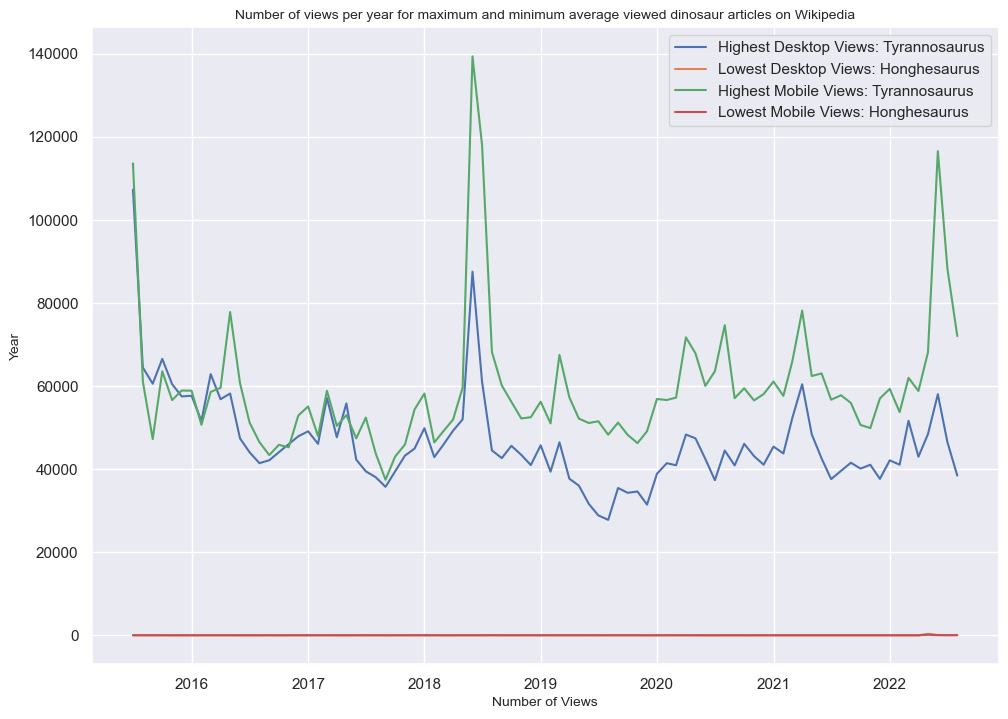

In [30]:
task_1_plot = plot_min_max_articles([desktop_highest_graph_values, 
                       desktop_lowest_graph_values,
                       mobile_highest_graph_values,
                       mobile_lowest_graph_values],
                      ['Highest Desktop Views: Tyrannosaurus',
                       'Lowest Desktop Views: Honghesaurus',
                       'Highest Mobile Views: Tyrannosaurus',
                       'Lowest Mobile Views: Honghesaurus'],
                      "visualizations/task_1.png"
                     )
task_1_plot

> Around mid-2018 the newest Jurassic World movie released, which explains the huge spike in mobile views in 2018. Similarily, the newest Jurassic World movie came out in 2022, also creating a spike.

### Task 2

> Top 10 Peak Page Views - A time series output for the top 10 article pages (the ones that had the highest peak over entire time) -- by access type. 

The top 10 peak page views are found by,
1) Finding the month with highest peak page views for each article
2) Ordering these articles by peak values
3) Taking these top 10 page views.

##### Helper Functions Specific for Task 2

In [79]:
def plot_peak_timeseries(desktop_df, mobile_df, save_plot_name = None):
    '''
        Plotting function to be used for task 2 only. This takes in the desktop, and mobile access DataFrames for
        articles needed to be plotted. Optionally it takes a save_plot_name to save the plot if wanted.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.lineplot()
    task_2_plot = None
    task_2_plot = plot_lineplot(task_2_plot, desktop_df, 'Desktop Top 10 Peak Articles Viewed', 'timestamp', 'views',  add_legend=True)
    task_2_plot = plot_lineplot(task_2_plot, mobile_df, 'Mobile Top 10 Peak Articles Viewed', 'timestamp', 'views')
    
    ax.set_xlabel("Number of Views", fontsize = 10)
    ax.set_ylabel("Year", fontsize = 10)
    ax.set_title('Number of views per month for top 10 peak viewed articles accessed via Mobile and Desktop', fontsize=10)
    
    # if wanted to save plot
    if save_plot_name: 
        task_2_plot.figure.savefig(save_plot_name)
        print(f'Task saved as : {save_plot_name}')
    
    return task_2_plot

def plot_lineplot(plot, df, line_label, x_values, y_values, add_legend=False):
    '''Helper function to plot each label in a legend for each line. '''
    unique_names = df['article'].unique()
    
    for i, name in enumerate(unique_names):
        subset = df[df['article'] == name]
        if add_legend:
            plot = sns.lineplot(x=x_values, y=y_values, data=subset, color=sns.color_palette()[i], label=f'Top accessed article: {i+1}')
        else:
            plot = sns.lineplot(x=x_values, y=y_values, data=subset, color=sns.color_palette()[i])
            
    return plot

> Below we find the top 10 peak article names and get their views per month. Top 10 is described in the task description above.

In [80]:
desktop_top_10_articles = find_top_10_peak_views_articles(desktop_df)
mobile_top_10_articles = find_top_10_peak_views_articles(mobile_df)
print(f'Top 10 peak articles accessed via Desktop: {desktop_top_10_articles}')
print(f'Top 10 peak articles accessed via Mobile:  {mobile_top_10_articles}')

Top 10 peak articles accessed via Desktop: ['Achelousaurus', 'Velociraptor', 'Tyrannosaurus', 'Halszkaraptor', 'Giganotosaurus', 'Spinosaurus', 'Lythronax', 'Nigersaurus', 'Borealopelta', 'Dilophosaurus']
Top 10 peak articles accessed via Mobile:  ['Nigersaurus', 'Deinocheirus', 'Giganotosaurus', 'Therizinosaurus', 'Velociraptor', 'Achelousaurus', 'Tyrannosaurus', 'Borealopelta', 'Dilophosaurus', 'Argentinosaurus']


In [81]:
desktop_top_10_articles_df = filter_articles_by_name(desktop_df, desktop_top_10_articles)
mobile_top_10_articles_df = filter_articles_by_name(mobile_df, mobile_top_10_articles)

> Visualization for Task 2 given the filtered article dataframes that we need

Task saved as : task_2.png


<AxesSubplot:title={'center':'Number of views per month for top 10 peak viewed articles accessed via Mobile and Desktop'}, xlabel='Number of Views', ylabel='Year'>

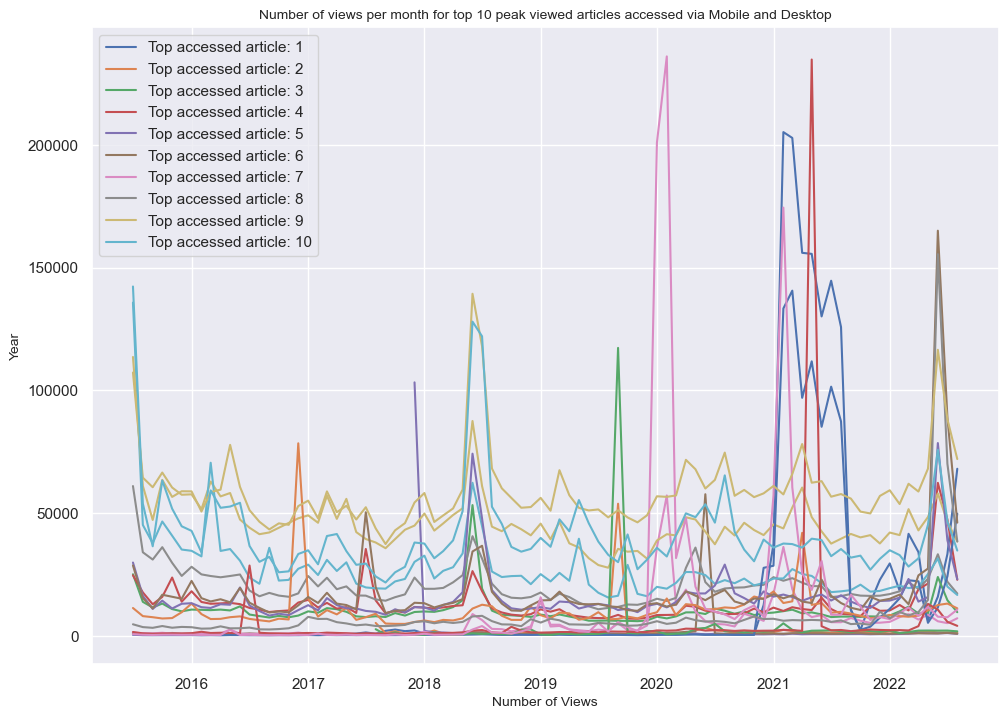

In [82]:
task_2_plot = plot_peak_timeseries(desktop_top_10_articles_df, mobile_top_10_articles_df, 'visualizations/task_2.png')
task_2_plot

### Task 3

> Fewest Months of Data - A time series output for articles that have the fewest months of data. There will only be 10 articles with fewest months of data for both Desktop and Mobile access.

##### Helper Functions Specific for Task 3

In [91]:
def plot_lowest_frequency_timeseries(desktop_df, mobile_df, save_plot_name=None):
    '''
        Plotting function to be used for task 3 only. This takes in the desktop, and mobile access DataFrames for
        articles needed to be plotted. Optionally it takes a save_plot_name to save the plot if wanted.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.lineplot()
    task_3_plot = None
    task_3_plot = plot_lineplot(task_3_plot, desktop_df, 'timestamp', 'views')
    task_3_plot = plot_lineplot(task_3_plot, mobile_df, 'timestamp', 'views')
    
    ax.set_xlabel('Number of Views', fontsize = 10)
    ax.set_ylabel('Year', fontsize = 10)
    ax.set_title('Number of views per month for Top 10 Least Viewed Articles accessed via Mobile and Desktop', fontsize=10)
    
    # if wanted to save plot
    if save_plot_name: 
        task_3_plot.figure.savefig(save_plot_name)
        print(f'Task saved as : {save_plot_name}')
    
    return task_3_plot

def plot_lineplot(plot, df, x_values, y_values):
    '''Helper function for task 3 to plot all unique lines'''
    unique_names = df['article'].unique()
    add_legend = True
    for i, name in enumerate(unique_names):
        subset = df[df['article'] == name]
        plot = sns.lineplot(x=x_values, y=y_values, data=subset, color=sns.color_palette()[i], label=f'Position:{i}: {name}')
        
    return plot

> Below we find the bottom 10 article names and get their views per month. How we get the "bottom 10" is explained in the task description above

In [92]:
desktop_df_bottom_10_names = find_bottom_10_article_names(desktop_df)
mobile_df_bottom_10_names = find_bottom_10_article_names(mobile_df)
print(f'Bottom 10 accessed articles via Desktop: {desktop_top_10_articles}')
print(f'Bottom 10 accessed articles via Mobile:  {mobile_top_10_articles}')

Bottom 10 accessed articles via Desktop: ['Achelousaurus', 'Velociraptor', 'Tyrannosaurus', 'Halszkaraptor', 'Giganotosaurus', 'Spinosaurus', 'Lythronax', 'Nigersaurus', 'Borealopelta', 'Dilophosaurus']
Bottom 10 accessed articles via Mobile:  ['Nigersaurus', 'Deinocheirus', 'Giganotosaurus', 'Therizinosaurus', 'Velociraptor', 'Achelousaurus', 'Tyrannosaurus', 'Borealopelta', 'Dilophosaurus', 'Argentinosaurus']


In [93]:
desktop_bottom_10_articles_df = filter_articles_by_name(desktop_df, desktop_df_bottom_10_names)
mobile_bottom_10_articles_df = filter_articles_by_name(mobile_df, mobile_df_bottom_10_names)

> Visualization for Task 3 given the filtered article dataframes that we need

Task saved as : task_3.png


<AxesSubplot:title={'center':'Number of views per month for Top 10 Least Viewed Articles accessed via Mobile and Desktop'}, xlabel='Number of Views', ylabel='Year'>

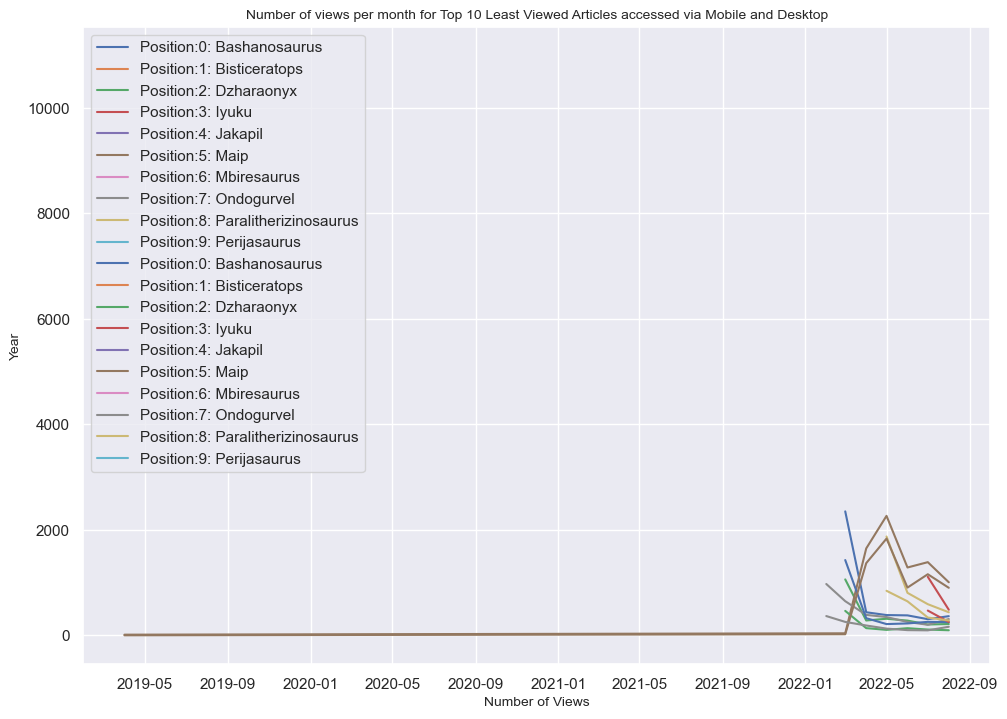

In [95]:
plot_lowest_frequency_timeseries(desktop_bottom_10_articles_df, mobile_bottom_10_articles_df, 'visualizations/task_3.png')